STARTER CODE

In [74]:
#Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [75]:
import numpy as np
import pandas as pd

In [76]:
 import datetime as dt

REFLECT TABLES INTO SQLALCHEMY ORM

In [77]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [34]:
 engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [78]:
# Create session
session = Session(engine)

EXPLORATORY CLIMATE ANALYSIS

In [79]:
# How many dates are recorded?
session.query(func.count(Measurement.date)).all()

[(19550)]

In [80]:
#Find earliest and latest date recorded
earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [81]:
# Calculate the date 1 year ago from the last data point in the database
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
for date in latestDate:
    print(date)

2017-08-23


In [82]:
#extract string from query object
latestDate = list(np.ravel(latestDate))[0]
#convert date string to datetime object
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

In [83]:
#extract year, month, and day as integers
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

In [84]:
#calculate one year before latest date
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

In [85]:
#query for dates and precipitation for the latest year
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

In [86]:
#convert query object to data frame and set index
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


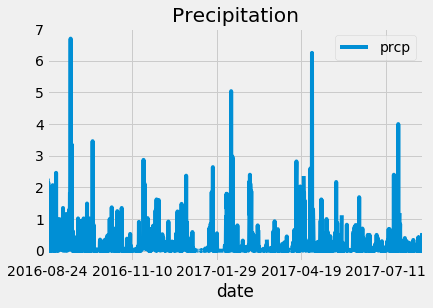

In [89]:
#plot with pandas: 08/23/16 - 8/23/17
rainTable.plot(title="Precipitation")

Use Pandas to calcualte the summary statistics for the precipitation data

In [90]:
#summarize the data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Design a query to show how many stations are available in this dataset?

In [91]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count() # id is the primary key

9

In [92]:
# Most active stations?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

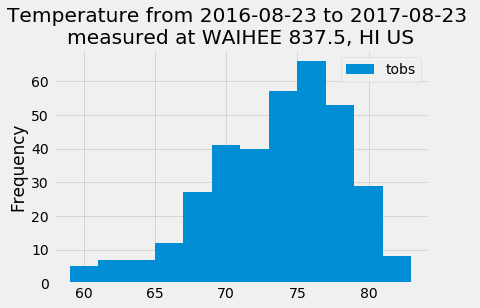

In [94]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {lateststr[0]} \nmeasured at {stationname}")
plt.legend()
# maxfreq = n.max()
# plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-05-28'
enddate = '2017-06-10'
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(71.0, 77.25581395348837, 82.0)

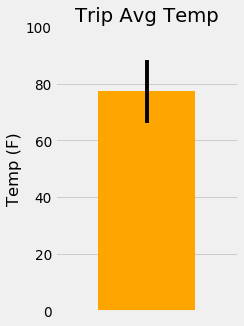

In [97]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [98]:
#query for precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= startdate)
                   .filter(Measurement.date <= enddate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",2.84,21.4517,-157.849,32.9
1,USC00513117,"KANEOHE 838.1, HI US",1.34,21.4234,-157.802,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.98,21.5213,-157.837,7
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.85,21.3331,-157.803,152.4
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.39,21.3356,-157.711,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.36,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


OPTIONAL CHALLENGE ASSIGNMENT

In [99]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [100]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startdate = '2020-05-28'
enddate = '2020-06-10'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[67.0, 74.27777777777777, 82.0],
 [64.0, 74.19607843137256, 80.0],
 [69.0, 74.33333333333333, 81.0],
 [68.0, 74.4, 81.0],
 [64.0, 74.6140350877193, 81.0],
 [65.0, 74.4, 81.0],
 [65.0, 74.03448275862068, 80.0],
 [65.0, 73.81818181818181, 81.0],
 [68.0, 74.85454545454546, 81.0],
 [70.0, 75.17543859649123, 80.0],
 [68.0, 75.07142857142857, 81.0],
 [70.0, 75.58620689655173, 81.0],
 [69.0, 75.15254237288136, 81.0],
 [68.0, 75.14285714285714, 81.0]]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
thistory = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
thistory['Date'] = tripdates
thistory = thistory.set_index("Date")
thistory

,tmin,tavg,tmax
Date,,,
2020-05-28,67.0,74.277778,82.0
2020-05-29,64.0,74.196078,80.0
2020-05-30,69.0,74.333333,81.0
2020-05-31,68.0,74.400000,81.0
2020-06-01,64.0,74.614035,81.0
2020-06-02,65.0,74.400000,81.0
2020-06-03,65.0,74.034483,80.0
2020-06-04,65.0,73.818182,81.0
2020-06-05,68.0,74.854545,81.0


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text xticklabel objects>)

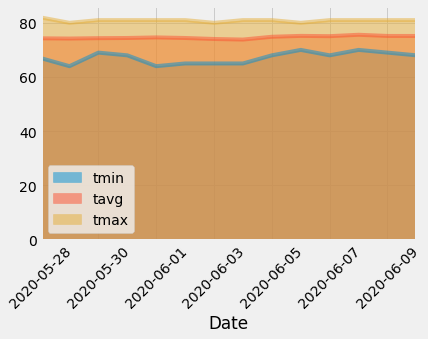

In [102]:
# Plot the daily normals as an area plot with `stacked=False`
thistory.plot.area(stacked=False)
plt.xticks(rotation=45)